# BiLRP visual explanation

In [1]:
%%capture 
%run "./shared.ipynb"

In [19]:
from python.bilrp_wrapper.model import *
from python.bilrp_wrapper.visualization import plot_pair_similar_features, visualize_bilrp_path

### Import trained model to explain

In [3]:
model = load_model('../models/model-18-4_pen1.h5')

### Load data

In [4]:
batch_size = 32
IMG_HEIGHT = 240
IMG_WIDTH = 240
val_dir = '../data/valid/confidence_19/'
test_dir = '../data/test/confidence_19/'

validation_image_generator = ImageDataGenerator(rescale=1./255)
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=val_dir,
                                                           shuffle=True,
                                                           classes=['LGG', 'HGG'],
                                                           color_mode="rgb",
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='sparse',
                                                           seed=42)
test_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=test_dir,
                                                           shuffle=True,
                                                           classes=['LGG', 'HGG'],
                                                           color_mode="rgb",
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='sparse',
                                                           seed=42)

Found 446 images belonging to 2 classes.
Found 246 images belonging to 2 classes.


In [5]:
train_images, train_labels, test_images, test_labels = [], [], [], []
for _ in range(round(val_data_gen.samples / batch_size)):
    (images, labels) = val_data_gen.next()
    train_images.extend(images)
    train_labels.extend(labels)
for _ in range(round(test_data_gen.samples / batch_size)):
    (images, labels) = test_data_gen.next()
    test_images.extend(images)
    test_labels.extend(labels)
    
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

## Wrapp original model to BiLRP wrapper

We have created BiLRPLayerModel which can wrapp any keras model to apply BiLRP to any layer

In [6]:
model.layers

In [7]:
# BiLRPLayerModel has 2 input parameters: model to explain; index of layer to explain
layer_model = BiLRPLayerModel(model, 8)
# Initialization of LRP. Define method and parameters 
layer_model.initialize_analyzer("lrp.sequential_preset_b", {})

/usr/local/lib/python3.6/dist-packages/innvestigate/analyzer/relevance_based/relevance_analyzer.py:557: DeprecationWarning: LRPSequentialPresetB is deprecated. Use LRPSequentialCompositeB instead
  DeprecationWarning)


In [8]:
# Train KNN classifier on selected hidden layer to predict most similar images to input image
layer_model.train_knn(train_images, train_labels)

#### Predict similar atlas images for input images
Predict 5 most similar images for input images with KNN

In [9]:
layer_model.get_neighbours_idx(test_images[:5])

array([[ 20, 395,   8, 156, 320],
       [404, 179,  86, 173, 340],
       [432,  38, 248, 251, 183],
       [ 45,   8, 350, 146, 123],
       [354,   9,  53, 258, 304]])

##  Get similarity between two images (get BiLRP of image pair)

* As a first, we will get BiLRP relevances between two images
* Then we use plotting function to visualize similar features between two images 

In [20]:
image1 = 2
image2 = 432
# Define poolstride to do not count every pixel but 8 pixels in one batch, 
# One red line will represent 8*8 pixels window
poolstride=[8]
# Get Bilrp
bi_lrp_relevances = layer_model.pair_similarity(test_images[image1], train_images[image2], poolstride, top_neurons=100)

In [21]:
bi_lrp_relevances.shape

(30, 30, 30, 30)

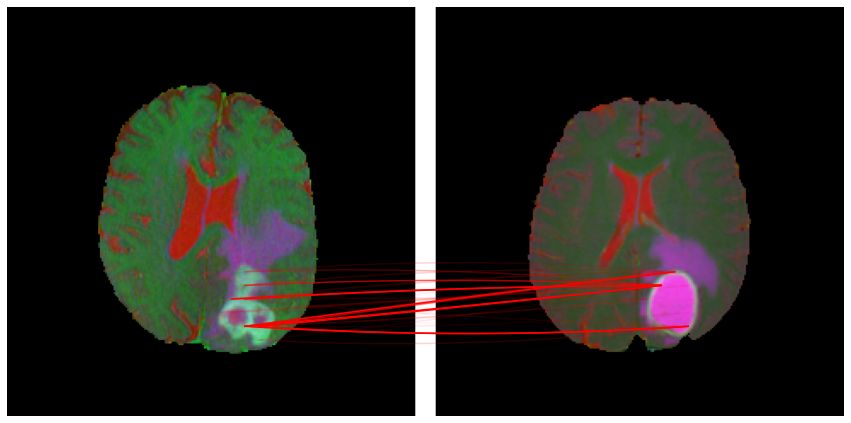

In [22]:
# Visualize similar features
plot_pair_similar_features(bi_lrp_relevances, test_images[image1], train_images[image2], poolstride)

In [13]:
analysis = layer_model.lrp([test_images[image1], train_images[image2]])['input_layer']

In [15]:
analysis = analysis / analysis.max()

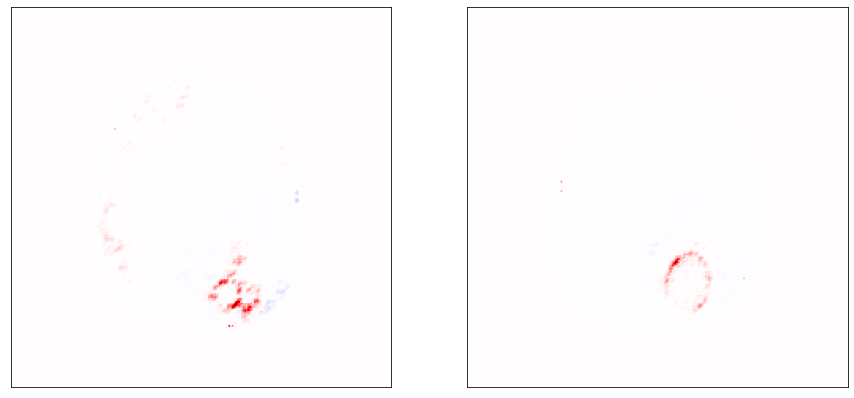

In [16]:
fig, axs = plt.subplots(1,2,figsize=(15, 20))
visualization.plot_lrp(analysis[0], axs[0])
visualization.plot_lrp(analysis[1], axs[1])

## Explain prediction of model with Bilrp explanation of most similar images on every layer

In [6]:
model.layers

In [7]:
# Select layers and create BiLRP model for each layer
selected_layers = [2,4,6,10]
bilrp_layers_model = [
    BiLRPLayerModel(model, layer_no, "lrp.sequential_preset_b", {}) for layer_no in selected_layers
]
for bilrp_model in bilrp_layers_model:
    bilrp_model.train_knn(train_images, train_labels)

/usr/local/lib/python3.6/dist-packages/innvestigate/analyzer/relevance_based/relevance_analyzer.py:557: DeprecationWarning: LRPSequentialPresetB is deprecated. Use LRPSequentialCompositeB instead
  DeprecationWarning)


In [8]:
image_idx = 2
poolstride=[8]
top_neurons = 20
target_image = test_images[image_idx]
prediction = model.predict(np.array([target_image])).argmax()
label = test_labels[image_idx]

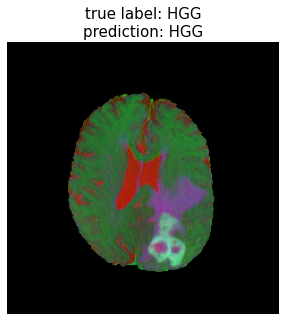

In [9]:
visualization.visualize_single_image(target_image, prediction, label, ['LGG', 'HGG'])

### Find most similar atlas image on every layer

In [10]:
# Get most similar images on everu layer
neighbours = [bilrp_model.get_neighbours_idx(np.array([target_image]))[0] for bilrp_model in bilrp_layers_model]

In [11]:
# Get BiLRP relevances for all pairs with target_image on every layer
layers_bilrp_relevances = [
    bilrp_layers_model[i].multiple_similarity(target_image,  train_images[n_arr], poolstride, top_neurons)
    for i, n_arr in enumerate(neighbours)
]

In [12]:
# relevances for 5 images
layers_bilrp_relevances[0].shape

(5, 30, 30, 30, 30)

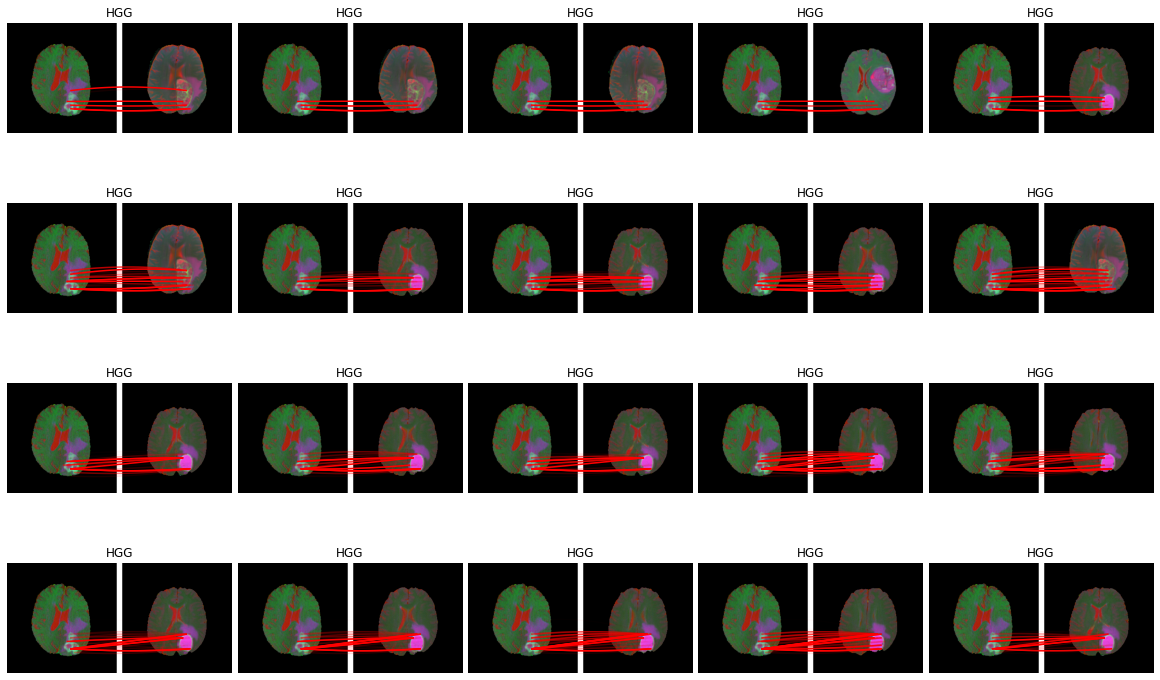

In [18]:
visualize_bilrp_path(neighbours, layers_bilrp_relevances, target_image, train_images, train_labels, ['LGG', 'HGG'], poolstride)